In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import os
from glob import glob
from PIL import Image


In [ ]:
drive.mount('/content/drive')

train_dir= "/content/drive/MyDrive/complete_set/training_set"
test_dir = "/content/drive/MyDrive/complete_set/testing_set"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_dataframe(base_dir):
  data=[]

  for label_name in ["benign", "malignant"]:
    class_dir =os.path.join(base_dir, label_name)
    label = 0 if label_name == "benign" else 1

    image_files= glob(os.path.join(class_dir, "*.png"))
    image_files= [f for f in image_files if "_mask" not in f]

    for image_path in image_files:
      study_id = os.path.splitext(os.path.basename(image_path))[0]

      mask_paths= glob(os.path.join(class_dir, f"{study_id}_mask*.png"))

      for mask_path in mask_paths:
        data.append({
            "study_id" :study_id,
            "class_label" : label,
            "image_path" : image_path,
            "mask_path" : mask_path
        })
  df =pd.DataFrame(data)
  return df

def create_test_set(base_dir):
	data=[]
	image_files = glob(os.path.join(base_dir, "*.png"))
	image_files = [f for f in image_files if  "_mask" not in f]

	for image_path in image_files:
		study_id = os.path.splitext(os.path.basename(image_path))[0]
		mask_paths= glob(os.path.join(base_dir, f"{study_id}_mask*.png"))
		for mask_path in mask_paths:
			data.append({
				"study_id" : study_id,
				"image_path" : image_path,
				"mask_path" : mask_path
			})
	df = pd.DataFrame(data)
	return df

In [ ]:
train_df =create_dataframe(train_dir)
test_df =create_test_set(test_dir)
print(train_df.head(5))
print(test_df.head(5))
print(f"Train Samples: {len(train_df)}")
print(f"Test Samples: {len(test_df)}")

       study_id  class_label  \
0  benign (123)            0   
1  benign (103)            0   
2  benign (148)            0   
3  benign (106)            0   
4  benign (115)            0   

                                          image_path  \
0  /content/drive/MyDrive/complete_set/training_s...   
1  /content/drive/MyDrive/complete_set/training_s...   
2  /content/drive/MyDrive/complete_set/training_s...   
3  /content/drive/MyDrive/complete_set/training_s...   
4  /content/drive/MyDrive/complete_set/training_s...   

                                           mask_path  
0  /content/drive/MyDrive/complete_set/training_s...  
1  /content/drive/MyDrive/complete_set/training_s...  
2  /content/drive/MyDrive/complete_set/training_s...  
3  /content/drive/MyDrive/complete_set/training_s...  
4  /content/drive/MyDrive/complete_set/training_s...  
  study_id                                         image_path  \
0     P025  /content/drive/MyDrive/complete_set/testing_se...   
1     P011

In [ ]:
def extract_features(image_path):
  img= Image.open(image_path).convert("L")
  array=np.array(img)
  return{
      "mean": np.mean(array),
      "std": np.std(array),
      "min": np.min(array),
      "max": np.max(array),
  }

features=[]
labels=[]

for _, row in train_df.iterrows():
  f= extract_features(row["image_path"])
  features.append(f)
  labels.append(row["class_label"])

In [ ]:
def training_priority_assignment(label, mean_val):
  label = str(label)
  mean_val = float(np.ravel(mean_val)[0])


  if label == "Malignant":
      if mean_val > 150:
          return "High"
      elif mean_val > 100:
          return "Medium"
      else:
          return "Low"
  else:
      return "Low"

In [ ]:
def assign_priority(prob, mean_val):
    if prob > 0.9 or (prob > 0.75 and mean_val > 150):
        return "High"
    elif prob > 0.6 or mean_val > 120:
        return "Medium"
    else:
        return "Low"

Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84        85
           1       0.47      0.32      0.38        28

    accuracy                           0.74       113
   macro avg       0.64      0.60      0.61       113
weighted avg       0.72      0.74      0.73       113



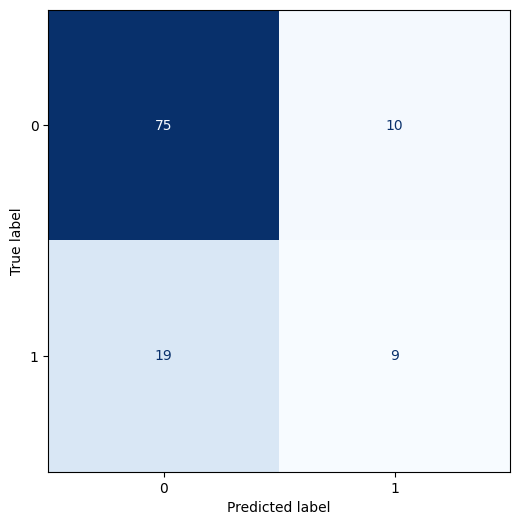

Sample: {'mean': 114.80317914107493, 'std': 60.150502354807976, 'min': 0.0, 'max': 255.0}
Predicted Health: Healthy
Actual Health: Unhealthy
Predicted Value for second sample: 0.00
Actual Value: 0.00


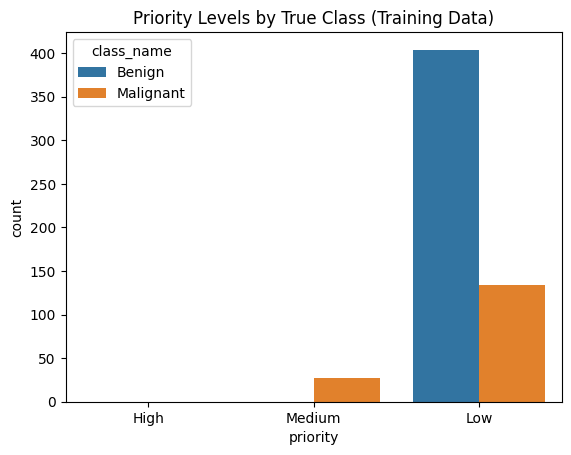

In [ ]:
# Get features and values for prediction
X=pd.DataFrame(features)
y=np.array(labels)

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#random forest regression
rfc= RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)
accuracy =accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
report_str = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report_str)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar= False)
plt.show()

#sample pick from the dataset
sample = X_test.iloc[0:1]
prediction = rfc.predict(sample)
actual_label = y_test[0]
# map numeric to readable labels
label_map = {0: "Healthy", 1: "Unhealthy"}

#converts to a dictionary for printing, then prints
sample_dict = sample.iloc[0].to_dict()
print(f"Sample: {sample_dict}")
print(f"Predicted Health: {'Unhealthy' if prediction[0] == 1 else 'Healthy'}")
print(f"Actual Health: {label_map[actual_label]}")

#Another sample, without the dictionary setup
single_data = X_test.iloc[[6]]
single_prediction = rfc.predict(single_data)
print(f"Predicted Value for second sample: {single_prediction[0]:.2f}")
print(f"Actual Value: {y_test[6]:.2f}")

#priority assignment for the training set begins here
train_df["class_label"] = y
label_map = {0: "Benign", 1: "Malignant"}
train_df["class_name"] = train_df["class_label"].map(label_map)

#concatenatin to make the numerical values available in the dataframe for manipulation
train_df = pd.concat([train_df.reset_index(drop=True), X.reset_index(drop=True)], axis=1)

#empty list of priorities
train_priorities = []

#populatin train_priorities
for i, row in train_df.iterrows():
    label = row["class_name"]
    mean_val = row["mean"]
    priority = training_priority_assignment(label, mean_val)
    train_priorities.append(priority)

#Assigning records their appropriate priorities
train_df["priority"] = train_priorities
sns.countplot(x="priority", hue="class_name", data=train_df, order=["High", "Medium", "Low"])
plt.title("Priority Levels by True Class (Training Data)")
plt.show()


  study_id                                         image_path  \
0     P025  /content/drive/MyDrive/complete_set/testing_se...   
1     P011  /content/drive/MyDrive/complete_set/testing_se...   
2     P004  /content/drive/MyDrive/complete_set/testing_se...   
3     P021  /content/drive/MyDrive/complete_set/testing_se...   
4     P034  /content/drive/MyDrive/complete_set/testing_se...   

                                           mask_path  predicted_label  \
0  /content/drive/MyDrive/complete_set/testing_se...                0   
1  /content/drive/MyDrive/complete_set/testing_se...                1   
2  /content/drive/MyDrive/complete_set/testing_se...                0   
3  /content/drive/MyDrive/complete_set/testing_se...                0   
4  /content/drive/MyDrive/complete_set/testing_se...                0   

  predicted_class  prob_malignant  prob_benign priority  
0          Benign            0.24         0.76      Low  
1       Malignant            0.67         0.33   Mediu

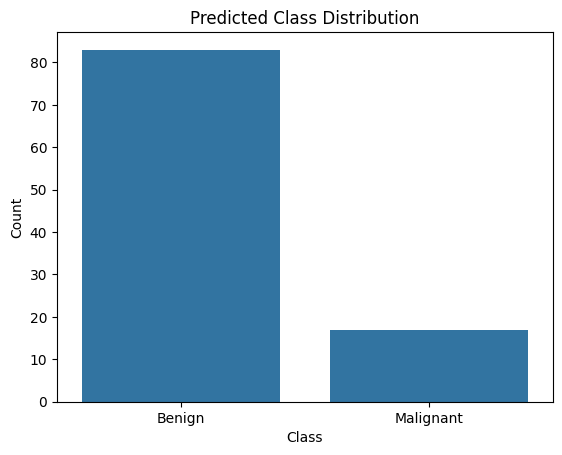

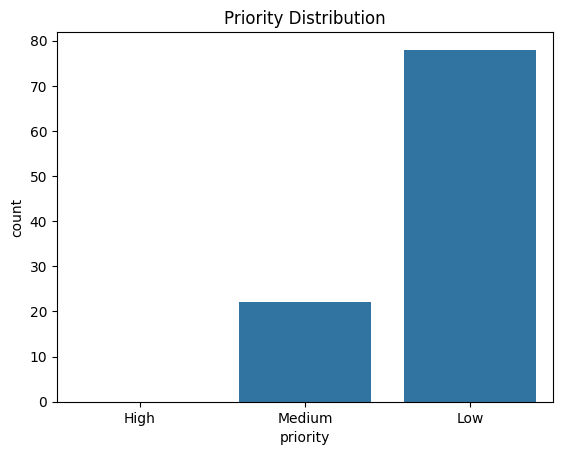

In [ ]:
#create list for test features
test_features=[]

# features to list
for _, row in test_df.iterrows():
  f = extract_features(row["image_path"])
  test_features.append(f)

X_validate= pd.DataFrame(test_features)

valid_predictions = rfc.predict(X_validate)
test_df['predicted_label'] = valid_predictions

#create columns for images' probability of benignity or malignancy
test_df["prob_malignant"] = rfc.predict_proba(X_validate)[:, 1]
test_df["prob_benign"] = rfc.predict_proba(X_validate)[:, 0]

#Attach numeric values to the diagnosis type
label_map={0: "Benign", 1: "Malignant"}
test_df["predicted_class"]= test_df["predicted_label"].map(label_map)

#create an empty priority list
priority_list=[]

#populate the priority list
for _, row in test_df.iterrows():
  prob=row["prob_malignant"]
  mean=X_validate.loc[row.name, "mean"]
  priority= assign_priority(prob, mean)
  priority_list.append(priority)

#assign records their respective priorities
test_df["priority"] = priority_list
print(test_df.head())

#visualize figures of predicted classes
counts= test_df["predicted_class"].value_counts()

#barplot
sns.barplot(x=counts.index, y=counts.values)
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#visualize the probabilities
sns.countplot(data=test_df, x="priority", order=["High", "Medium", "Low"])
plt.title("Priority Distribution")
plt.show()